In [1]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import glob

# Set the dataset path
data_path = '/content/drive/MyDrive/RoadSavior/archive'

# Get the image and mask file paths
train_image_paths = sorted(glob.glob(os.path.join(data_path, 'train', '*_sat.jpg')))
train_mask_paths = sorted(glob.glob(os.path.join(data_path, 'train', '*_mask.png')))
val_image_paths = sorted(glob.glob(os.path.join(data_path, 'valid', '*_sat.jpg')))
val_mask_paths = sorted(glob.glob(os.path.join(data_path, 'valid', '*_mask.png')))

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)



Mounted at /content/drive
Number of training images: 6226
Number of training masks: 6226
Number of validation images: 1243
Number of validation masks: 0


In [3]:
from sklearn.model_selection import train_test_split

# Split the training dataset into train and validation subsets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42
)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

Number of training images: 4980
Number of training masks: 4980
Number of validation images: 1246
Number of validation masks: 1246


In [4]:
# Define functions to load and preprocess the dataset

def load_images(path, img_type):
    return sorted(glob(os.path.join(path, f"*{img_type}")))

def read_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

def binarize_mask(mask, threshold=128):
    mask[mask > threshold] = 255
    mask[mask <= threshold] = 0
    return mask

def normalize(image, mask):
    image = image / 255.0
    mask = mask / 255.0
    return image, mask


In [5]:
# Create a data generator to load and preprocess images and masks in batches:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, dim=(256, 256), n_channels=3, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, idx in enumerate(indexes):
            image = cv2.imread(self.image_paths[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

            image = cv2.resize(image, self.dim)
            mask = cv2.resize(mask, self.dim)

            X[i] = image / 255.0
            y[i] = np.expand_dims(mask, axis=-1) / 255.0

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
# Define the U-Net model for road segmentation:

def unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Expanding path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [8]:
# Compile and train the model:

input_shape = (256, 256, 3)
batch_size = 8
epochs = 10

model = unet(input_shape=input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

train_gen = DataGenerator(train_image_paths, train_mask_paths, batch_size=batch_size)
val_gen = DataGenerator(val_image_paths, val_mask_paths, batch_size=batch_size)

callbacks = [
    ModelCheckpoint('unet_road_segmentation.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_image_paths) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_image_paths) // batch_size,
    callbacks=callbacks
)

Epoch 1/10
622/622 [==============================] - 633s 951ms/step - loss: 0.5364 - accuracy: 0.8419 - val_loss: 0.3490 - val_accuracy: 0.9508 - lr: 1.0000e-04
Epoch 2/10
622/622 [==============================] - 385s 618ms/step - loss: 0.2642 - accuracy: 0.9589 - val_loss: 0.1804 - val_accuracy: 0.9623 - lr: 1.0000e-04
Epoch 3/10
622/622 [==============================] - 385s 619ms/step - loss: 0.1432 - accuracy: 0.9656 - val_loss: 0.1138 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 4/10
622/622 [==============================] - 383s 615ms/step - loss: 0.0998 - accuracy: 0.9681 - val_loss: 0.0925 - val_accuracy: 0.9675 - lr: 1.0000e-04
Epoch 5/10
622/622 [==============================] - 384s 618ms/step - loss: 0.0821 - accuracy: 0.9696 - val_loss: 0.0808 - val_accuracy: 0.9679 - lr: 1.0000e-04
Epoch 6/10
622/622 [==============================] - 384s 617ms/step - loss: 0.0718 - accuracy: 0.9711 - val_loss: 0.0743 - val_accuracy: 0.9693 - lr: 1.0000e-04
Epoch 7/10
622/622 [==

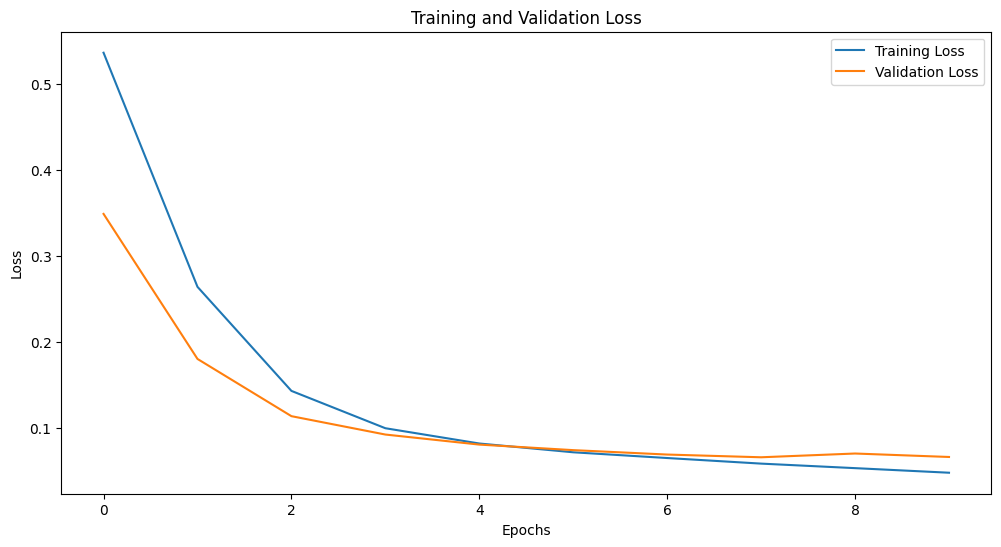

In [10]:
# Visualize the results:

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

1/1 [==============================] - 0s 20ms/step


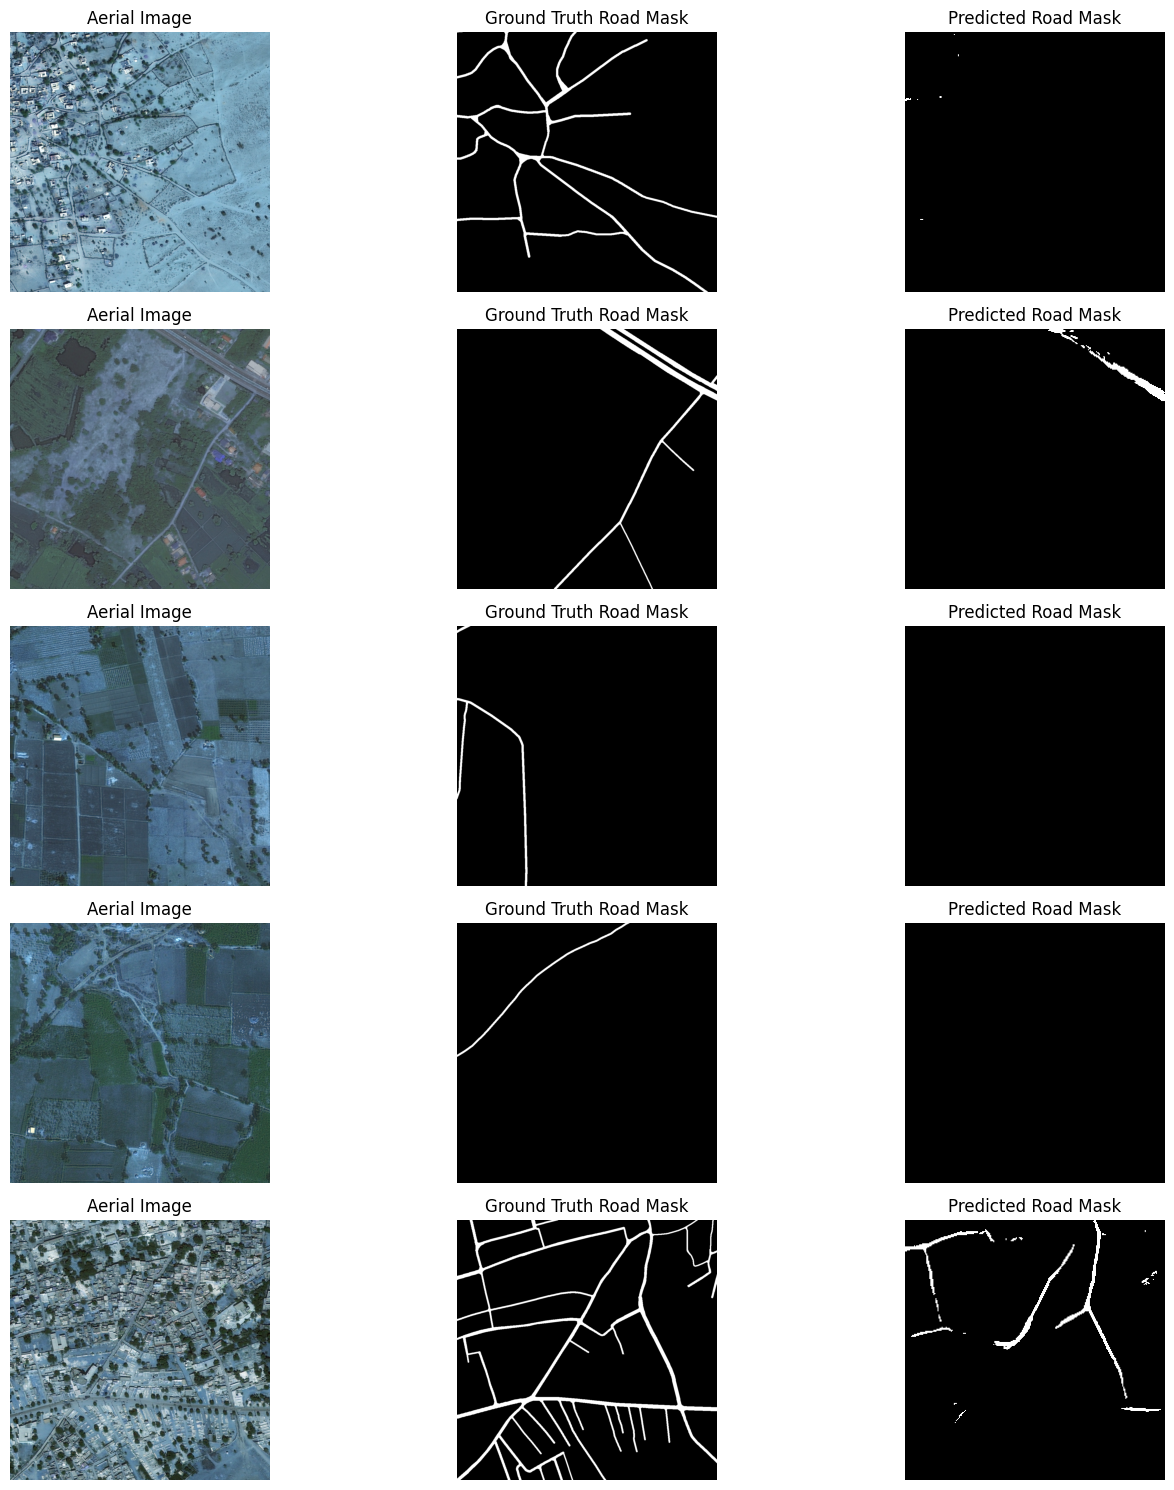

In [11]:
import random

# Function to predict the mask
def predict_mask(model, image):
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    mask = model.predict(image)
    mask = np.squeeze(mask)
    mask = cv2.resize(mask, (256, 256))
    return mask

# Function to visualize the results
def visualize_results(image_paths, mask_paths, model, num_samples=5):
    fig, ax = plt.subplots(num_samples, 3, figsize=(15, 15))

    for i in range(num_samples):
        idx = random.randint(0, len(image_paths) - 1)
        image, gt_mask = read_image_and_mask(image_paths[idx], mask_paths[idx])
        gt_mask = binarize_mask(gt_mask)
        pred_mask = predict_mask(model, image)
        pred_mask = binarize_mask(pred_mask * 255)

        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Aerial Image")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(gt_mask, cmap="gray")
        ax[i, 1].set_title("Ground Truth Road Mask")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(pred_mask, cmap="gray")
        ax[i, 2].set_title("Predicted Road Mask")
        ax[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_results(val_image_paths, val_mask_paths, model)
